# Neural Network from Scratch

#### Tensorflow is only used for loading DATASET

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

2024-06-30 12:15:06.947973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 12:15:06.948007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 12:15:06.949177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 12:15:06.954654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 12:15:07.481708: W tensorflow/compiler/tf2

In [2]:
def one_hot(x, depth):
    res=[]
    for i in range(len(x)):
        tmp = [0 for i in range(depth)]
        tmp[x[i]] = 1
        tmp = np.array(tmp)
        res.append(tmp)
    res = np.array(res)
    return res

In [3]:
(train_data, train_label), (test_data, test_label) =mnist.load_data()

train_data = train_data.reshape((60000, 28*28))
test_data = test_data.reshape((10000, 28*28))

test_label = one_hot(test_label, 10)
train_label = one_hot(train_label, 10)

In [4]:
train_data = train_data / 255

In [5]:
class Input():
    def __init__(self, shape):
        self.type = "Input"
        self.shape = shape
        
    def operate(self, x):
        self.Z = np.array(x, copy=True)
        return self.Z
        
class Dense():
    def __init__(self, shape, prev):
        self.type = "Dense"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)
        
    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return relu(self.Z)
    
    def ret(self, x):
        return self.Z

class Output():
    def __init__(self, shape, prev):
        self.type = "Output"
        self.shape = shape
        self.prev = prev
        self.W = np.random.uniform(-.5, .5, size=(self.shape, self.prev.shape))
        self.B = np.random.uniform(-.5, .5,size=self.shape)
        self.grad_W = np.zeros((self.shape, self.prev.shape))
        self.grad_Z = np.zeros(self.prev.shape)
        self.grad_B = np.zeros(shape)
        self.grad_loss = np.zeros(shape)
        
    def operate(self, x):
        self.Z = np.matmul(self.W, x) + self.B
        return softmax(self.Z)
    
    def ret(self, x):
        return self.Z

In [6]:
def relu(x):
    return np.maximum(0,x)

def softmax(X):
    Z = X - np.max(X)
    return np.exp(Z)/(np.sum(np.exp(Z), axis=0))

def grad_Z(w, z_curr, z_prev, dz_next, act):        #Calculating dLoss wrt dz_prev
    grad = np.zeros(z_prev.shape)
    if act == "relu":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                if z_curr[j] > 0:                   #coz dReLU/dZ whould be zero
                    grad[i] += dz_next[j]*1*w[j][i]
    elif act == "softmax":
        for i in range(z_prev.shape[0]):
            for j in range(z_curr.shape[0]):
                for k in range(dz_next.shape[0]):
                    if k == j:
                        grad[i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*w[j][i]
                    else:
                        grad[i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*w[j][i]
    return grad
    
def grad_W(w, z_curr, z_prev, dz_next, act):         # Z = matmul(W,Z_prev) + B
    grad = np.zeros(w.shape)
    if act == "relu":
        for j in range(w.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                for i in range(w.shape[1]):
                    grad[j][i] = dz_next[j]*1*z_prev[i]
    elif act == "softmax":
        for j in range(w.shape[0]):
            for i in range(w.shape[1]):
                for k in range(dz_next.shape[0]):
                    if j == k:
                        grad[j][i] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*z_prev[i]
                    else:
                        grad[j][i] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*z_prev[i]
    return grad

def grad_B(b, z_curr, dz_next, act):
    grad = np.zeros(b.shape)
    if act == "relu":
        for j in range(b.shape[0]):
            if z_curr[j] > 0:                       #coz dReLU/dZ whould be zero
                grad[j] =  dz_next[j] * 1 * 1
    elif act == "softmax":
        for j in range(b.shape[0]):
            for k in range(dz_next.shape[0]):
                if j == k:
                    grad[j] += dz_next[k]*(softmax(z_curr)[k] - (softmax(z_curr)[k])**2)*1
                else:
                    grad[j] += dz_next[k]*(-1 * softmax(z_curr)[j] * softmax(z_curr)[k])*1
    return grad

In [7]:
class model():
    def __init__(self):
        self.step_size = 0.01
        self.epochs = 2
        self.m = 32
        self.batch_acc = []
    
    def make(self, inputs, outputs, optimizer):
        self.comp_graph = []
        self.input_layer = inputs
        self.output_layer = outputs
        i = outputs
        while i.type != "Input":
            self.comp_graph.append(i)
            i=i.prev
        
        if (optimizer == "adam"):
            self.adam_init()
            self.optimizer = self.adam
        elif (optimizer == "RMSprop"):
            self.RMSprop_init()
            self.optimizer = self.RMSprop
        else:
            self.step_size = 0.01
            self.optimizer = self.SGD
            
    def SGD(self, x, grad, layer, sub_typ):
        return (x - self.step_size*grad)
        
    def adam_init(self):
        #Hyper Parameters
        self.a = 0.1
        self.b1 = 0.9
        self.b2 = 0.999
        self.e = 10e-8
        
        #t, m, v STORING THE HISTORY
        self.pram = {i:{'W':{'t':0, 'm':np.zeros(i.W.shape), 'v':np.zeros(i.W.shape)},
                        'B':{'t':0, 'm':np.zeros(i.B.shape), 'v':np.zeros(i.B.shape)}} for i in self.comp_graph}
        
    def adam(self, x, grad, layer, sub_typ):
        self.pram[layer][sub_typ]['t'] += 1
        self.pram[layer][sub_typ]['m'] = self.b1 * self.pram[layer][sub_typ]['m'] + (1-self.b1) * (np.power(grad,1))
        self.pram[layer][sub_typ]['v'] = self.b2 * self.pram[layer][sub_typ]['v'] + (1-self.b2) * (np.power(grad,2))
        corr_m = self.pram[layer][sub_typ]['m']/(1 - np.power(self.b1, self.pram[layer][sub_typ]['t']))
        corr_v = self.pram[layer][sub_typ]['v']/(1 - np.power(self.b2, self.pram[layer][sub_typ]['t']))
        x = x - self.a * (corr_m/(np.add(np.power(corr_v, 0.5), self.e)))
        return x
            
    def RMSprop_init(self):
        self.a = 0.1
        self.b2 = 0.9
        self.e = 10e-8
        self.pram = {i:{'W':{'v':np.zeros(i.W.shape)},
                        'B':{'v':np.zeros(i.B.shape)}} for i in self.comp_graph}
        
    def RMSprop(self, x, grad, layer, sub_typ):
        self.pram[layer][sub_typ]['v'] = self.b2 * self.pram[layer][sub_typ]['v'] + (1-self.b2) * (np.power(grad,2))
        x = x - self.a * (grad/(np.add(np.power(self.pram[layer][sub_typ]['v'], 0.5), self.e)))
        return x
        
    def fit(self, X, Y):
        
        Y.flags.writeable = False
        X.flags.writeable = False
        correct_pred = 0

        for i in range(len(X)):
            #forward pass
            i_copy = i
            i = i%self.m
            
            x = self.input_layer.operate(X[i])
            for j in range(-1, -1*len(self.comp_graph)-1, -1):
                x = self.comp_graph[j].operate(x)

            if np.argmax(x) == np.argmax(Y[i]):
                correct_pred += 1

            for e in range(self.epochs):
                #backward pass
                #Signatures
                #grad_W(w, z_curr, z_prev, dz_next, act)
                #grad_B(b, z_curr, dz_next, act)
                self.output_layer.grad_loss = (-2)*(Y[i] - softmax(self.output_layer.Z))/len(Y[i])
                
                self.output_layer.grad_W = grad_W(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")
                
                self.output_layer.grad_Z = grad_Z(self.output_layer.W, self.output_layer.Z,
                                                  self.output_layer.prev.Z, self.output_layer.grad_loss, "softmax")
                
                self.output_layer.grad_B = grad_B(self.output_layer.B,
                                                  self.output_layer.Z ,self.output_layer.grad_loss, "softmax")
 
                self.output_layer.W = self.optimizer(self.output_layer.W, self.output_layer.grad_W,
                                                     self.output_layer, "W")
                self.output_layer.B = self.optimizer(self.output_layer.B, self.output_layer.grad_B,
                                                     self.output_layer, "B")
                    
                self.comp_graph.append(self.comp_graph[-1].prev) #Quick Fix, Don't Look Here :-D
                
                for k in range(1, len(self.comp_graph)-1):
                    self.comp_graph[k].grad_W = grad_W(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")
                    
                    self.comp_graph[k].grad_Z = grad_Z(self.comp_graph[k].W, self.comp_graph[k].Z,
                                                       self.comp_graph[k+1].Z, self.comp_graph[k-1].grad_Z, "relu")
                    
                    self.comp_graph[k].grad_B = grad_B(self.comp_graph[k].B,
                                                       self.comp_graph[k].Z, self.comp_graph[k-1].grad_Z, "relu")

                    self.comp_graph[k].W = self.optimizer(self.comp_graph[k].W, self.comp_graph[k].grad_W,
                                                     self.comp_graph[k], "W")
                    self.comp_graph[k].B = self.optimizer(self.comp_graph[k].B, self.comp_graph[k].grad_B,
                                                     self.comp_graph[k], "B")
                
                self.comp_graph.pop(-1)                         #Quick Fix, Don't Look Here :-D
            
            i = i_copy
            if (i%32 == 0):
                self.batch_acc.append(correct_pred/32)
                print(correct_pred/32, "Total Processed", i)
                correct_pred = 0
    
    def predict (self, X):
        x = self.input_layer.operate(X)
        for i in range(-1, -1*len(self.comp_graph)-1, -1):
            x = self.comp_graph[i].operate(x)
        return x

In [8]:
'''
For adding new layer just put the "output size" the input size 
will be ajusted automatically from the prev layer output
'''

inputs = Input(28*28)
x = Dense(28*2 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

# Testing SGD, RMSprop and Adam with same weights initialization
##### SGD doesn't learn well with small steps but Adam works well with small steps

In [9]:
inputs = Input(28*28)
x = Dense(28*2 ,inputs)
outputs = Output(10 ,x)

digit_classifier = model()

x_W = x.W
x_B = x.B

outputs_W = outputs.W
outputs_B = outputs.B

In [10]:

# SGD

digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="SGD")
digit_classifier.step_size = 0.1      #Step size if you are using SGD
digit_classifier.epochs = 1           #No of Epochs
digit_classifier.a = 0.001            #Step size if you are using Adam
digit_classifier.m = 9999999          #This will repeat the images starting from image 0 to m-1 in train set
                                      #This heps me to check if the model is atleast overfitting

digit_classifier.fit(train_data[:3200], train_label[:3200])

0.0 Total Processed 0
0.25 Total Processed 32
0.15625 Total Processed 64
0.09375 Total Processed 96
0.1875 Total Processed 128
0.21875 Total Processed 160
0.25 Total Processed 192
0.1875 Total Processed 224
0.28125 Total Processed 256
0.25 Total Processed 288
0.25 Total Processed 320
0.25 Total Processed 352
0.3125 Total Processed 384
0.34375 Total Processed 416
0.375 Total Processed 448
0.25 Total Processed 480
0.15625 Total Processed 512
0.3125 Total Processed 544
0.34375 Total Processed 576
0.3125 Total Processed 608
0.15625 Total Processed 640
0.21875 Total Processed 672
0.28125 Total Processed 704
0.46875 Total Processed 736
0.34375 Total Processed 768
0.34375 Total Processed 800
0.46875 Total Processed 832
0.34375 Total Processed 864
0.34375 Total Processed 896
0.25 Total Processed 928
0.28125 Total Processed 960
0.3125 Total Processed 992
0.375 Total Processed 1024
0.375 Total Processed 1056
0.25 Total Processed 1088
0.46875 Total Processed 1120
0.46875 Total Processed 1152
0.40

##          Testing on ALL 10,000 samples in test set for SGD

In [11]:
correct_count = 0

for i in range(len(test_data)):
    if np.argmax(digit_classifier.predict(test_data[i])) == np.argmax(test_label[i]):
        correct_count += 1
print(f"Accuracy: {correct_count/len(test_data)}")

Accuracy: 0.6694


In [12]:
SGD_performance = digit_classifier.batch_acc
digit_classifier.batch_acc = []

x.W = x_W
x.B = x_B

outputs.W = outputs_W
outputs.B = outputs_B

In [13]:

# Adam

digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="adam")
digit_classifier.step_size = 0.001
digit_classifier.epochs = 1
digit_classifier.a = 0.001
digit_classifier.m = 9999999

digit_classifier.fit(train_data[:3200], train_label[:3200])

0.0 Total Processed 0
0.21875 Total Processed 32
0.15625 Total Processed 64
0.09375 Total Processed 96
0.28125 Total Processed 128
0.21875 Total Processed 160
0.3125 Total Processed 192
0.25 Total Processed 224
0.4375 Total Processed 256
0.34375 Total Processed 288
0.40625 Total Processed 320
0.40625 Total Processed 352
0.3125 Total Processed 384
0.375 Total Processed 416
0.5625 Total Processed 448
0.40625 Total Processed 480
0.21875 Total Processed 512
0.375 Total Processed 544
0.5 Total Processed 576
0.375 Total Processed 608
0.3125 Total Processed 640
0.28125 Total Processed 672
0.28125 Total Processed 704
0.5 Total Processed 736
0.46875 Total Processed 768
0.53125 Total Processed 800
0.53125 Total Processed 832
0.5625 Total Processed 864
0.46875 Total Processed 896
0.375 Total Processed 928
0.375 Total Processed 960
0.53125 Total Processed 992
0.625 Total Processed 1024
0.625 Total Processed 1056
0.59375 Total Processed 1088
0.5625 Total Processed 1120
0.59375 Total Processed 1152


# Testing on all 10,000 samples in Test dataset

In [14]:
correct_count = 0

for i in range(len(test_data)):
    if np.argmax(digit_classifier.predict(test_data[i])) == np.argmax(test_label[i]):
        correct_count += 1
print(f"Accuracy: {correct_count/len(test_data)}")

Accuracy: 0.8163


In [15]:
Adam_performance = digit_classifier.batch_acc
digit_classifier.batch_acc = []

x.W = x_W
x.B = x_B

outputs.W = outputs_W
outputs.B = outputs_B

In [16]:

# RMSprop

digit_classifier.make(inputs=inputs, outputs=outputs, optimizer="RMSprop")
digit_classifier.step_size = 0.001
digit_classifier.epochs = 1
digit_classifier.a = 0.001
digit_classifier.m = 9999999

digit_classifier.fit(train_data[:3200], train_label[:3200])

RMSprop_performance = digit_classifier.batch_acc
digit_classifier.batch_acc = []

0.0 Total Processed 0
0.1875 Total Processed 32
0.125 Total Processed 64
0.0625 Total Processed 96
0.25 Total Processed 128
0.28125 Total Processed 160
0.25 Total Processed 192
0.15625 Total Processed 224
0.375 Total Processed 256
0.375 Total Processed 288
0.375 Total Processed 320
0.28125 Total Processed 352
0.28125 Total Processed 384
0.34375 Total Processed 416
0.46875 Total Processed 448
0.3125 Total Processed 480
0.28125 Total Processed 512
0.3125 Total Processed 544
0.5 Total Processed 576
0.375 Total Processed 608
0.25 Total Processed 640
0.28125 Total Processed 672
0.34375 Total Processed 704
0.5625 Total Processed 736
0.40625 Total Processed 768
0.46875 Total Processed 800
0.59375 Total Processed 832
0.4375 Total Processed 864
0.4375 Total Processed 896
0.375 Total Processed 928
0.375 Total Processed 960
0.5 Total Processed 992
0.53125 Total Processed 1024
0.4375 Total Processed 1056
0.46875 Total Processed 1088
0.5 Total Processed 1120
0.5625 Total Processed 1152
0.625 Total 

# Testing on all 10,000 samples in Test dataset

In [17]:
correct_count = 0

for i in range(len(test_data)):
    if np.argmax(digit_classifier.predict(test_data[i])) == np.argmax(test_label[i]):
        correct_count += 1
print(f"Accuracy: {correct_count/len(test_data)}")

Accuracy: 0.7993


# Performance SGD vs RMSprop vs Adam

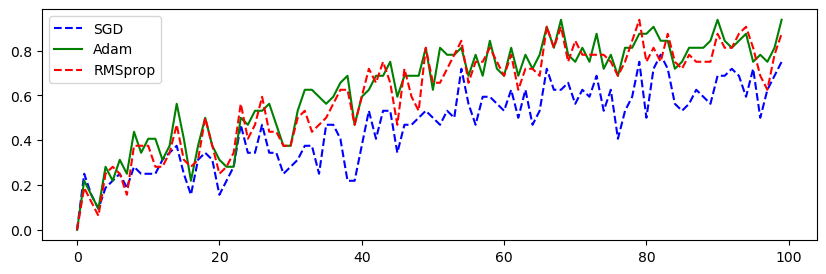

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(range(len(SGD_performance)), SGD_performance, 'b--', label = "SGD")
plt.plot(range(len(Adam_performance)), Adam_performance, 'g-', label = "Adam")
plt.plot(range(len(RMSprop_performance)), RMSprop_performance, 'r--', label = "RMSprop")
plt.legend()
plt.show()

In [19]:
'''
Do not execute this cell. Basically i did a "quick fix" in the BackProp, sometimes if the code is intruptted in
the BackProp then we need to manually remove the input layer from the comp_graph so we can run the code without
reinitializing the weights
'''
digit_classifier.comp_graph.pop(-1)